# Polynomial Ridge Regression


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Loading the data

def load_data():
    from sklearn.model_selection import train_test_split

    data = np.genfromtxt('time_temp_2016.tsv', delimiter='\t')
    
    x = data[:, 0]
    x = x.reshape((x.shape[0], 1))
    y = data[:, 1]
    
    train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(x, y, test_size=0.33, random_state=42)
    
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))
    
    return train_set_x.T, test_set_x.T, train_set_y, test_set_y, x.T

train_set_x, test_set_x, train_set_y, test_set_y, full_feature_set_for_plot = load_data()

In [4]:
print(train_set_x.shape, train_set_y.shape, test_set_x.shape, test_set_y.shape)

(1, 245) (1, 245) (1, 121) (1, 121)


In [5]:
m_train = train_set_x.shape[1]
m_test = test_set_x.shape[1]


print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))

print ("\ntrain_set_x shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 245
Number of testing examples: m_test = 121

train_set_x shape: (1, 245)
train_set_y shape: (1, 245)
test_set_x shape: (1, 121)
test_set_y shape: (1, 121)


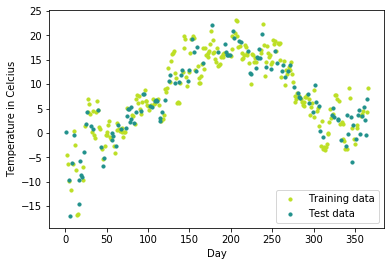

In [6]:
# Color map
cmap = plt.get_cmap('viridis')

# Plot the results
m1 = plt.scatter(366 * train_set_x, train_set_y, color=cmap(0.9), s=10)
m2 = plt.scatter(366 * test_set_x, test_set_y, color=cmap(0.5), s=10)
plt.xlabel('Day')
plt.ylabel('Temperature in Celcius')
plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
plt.show()

##  Polynomial Ridge Regression algorithm
**Mathematical expression of the algorithm**:
For one example $x^{(i)}$:

Main trick of polynomial regression - feature combination under predefined degree.
Let's define our $degree = 3$ and $x^{(i)} = (x_{1})$ - so that we have only one feature as in our current dataset for the sake of simplicity(later you will see generalized solution for any amount of features and any degree).

So, having $degree = 3$ and $x^{(i)}$ we transform our feature vector to be:
$$x^{(i)} = ((x^{(i)})^0, (x^{(i)})^1, (x^{(i)})^2, (x^{(i)})^3)$$

Having more than 1 features would cause combinations with replacements for each feature under each degree in range [0, $degree$].

After that step we have regular well known process, but in this lab we will use a little trick with bias.
Main idea is to use $(x^{(i)})^0 = 1$ as bias variable to each training example. It gives us an ability to count our bias inside of the weights vector on the first position too. 

So, predictor function:
$$h^{(i)} =  w^T x^{(i)} \tag{1}$$

<b>Ridge</b> a.k.a <b>L2 Regularization</b>.
Having really high order polynomial function we can easily overfit on our training set.
The main technique to prevent overfitting called regularization.
You should already be familiar with theory of l2 regularization. Our cost function will look like this:

The cost is then computed by summing squared diff over all training examples:
$$J = \frac{1}{2}\sum_{i=1}^{m}(h^{(i)} - y^{(i)})^{2} + \frac{1}{2}\lambda ||w||^2_2\tag{2}$$

Where $\lambda$ is regularization term and $||w||_2$ is Euclidean norm.

Now, only gradient have to be defined.
$$X = (x^{(1)}, x^{(2)}, ..., x^{(m-1)}, x^{(m)})$$
$$H = w^T X = (h^{(1)}, h^{(2)}, ..., h^{(m-1)}, h^{(m)})$$

$$ \frac{\partial J}{\partial w} = X(H-Y)^T + \lambda w \tag{3}$$



### Helper utilities

We create function polynomial_features to transform our flat input features into features of higher degrees.

As example for degree=3 and features $(x_1, x_2, x_3)$ we will get:

$$((x_1, x_2, x_3),3) -> (1, x_1, x_2, x_3, x^2_1, x_1 x_2, x_1 x_3, x^2_2, x_2 x_3, x^2_3, x^3_1, x^2_1 x_2, x^2_1 x_3,  x_1 x^2_2, x_1 x_2 x_3, x_1 x^2_3, x^3_2, x^2_2 x_3, x_2 x^2_3, x^3_3)$$

In [7]:
def polynomial_features(X, degree):
    
    from itertools import combinations_with_replacement 
    # combinations_with_replacement('ABC', 2) --> AA AB AC BB BC CC
    
    n_features, n_samples = np.shape(X)
    
    def index_combinations(): ## (1, 2) => [(1),(2),(1,1),(1,2),(2,2)]
        combs = [combinations_with_replacement(range(n_features), i) for i in range(0, degree + 1)]
        ##comb = [(),((1),(2)),((1,1),(1,2),(2,2))]
        flat_combs = [item for sublist in combs for item in sublist]
        ##flat_combs = [(1),(2),(1,1),(1,2),(2,2)]
        return flat_combs
    
    combinations = index_combinations()
    
    n_output_features = len(combinations)
    
    X_new = np.empty((n_output_features, n_samples))
    
    for i, index_combs in enumerate(combinations):  
        X_new[i, :] = np.prod(X[index_combs, :], axis=0)
        ## if index_combs == (1,2,3) =>  X_new[:,i] = X[:,1] * X[:,2] * X[:,3] 
    return X_new

We will be using mean squared error to evaluate accuracy of our model:

$$
MSE=\frac{1}{m}\sum_{i=1}^{m}{(h^{(i)} - y^{(i)})^2} 
$$

In [34]:
# GRADED FUNCTION: mean_squared_error

def mean_squared_error(y_true, y_pred):
    """ Returns the mean squared error between y_true and y_pred 
    
    Arguments:
    y_true -- array of true values
    y_pred -- array of predicted values
    
    Returns:
    mse -- mean squared error
    """
    mse = (1/np.shape(y_true)[-1]) * ((y_pred - y_true)**2).sum()

    return mse

In [35]:
print ("mse = " + str(mean_squared_error(np.array([1, 2, 3, 4]), np.array([2, 3, 4, 6]))))

mse = 1.75



The cost function:
$$J = \frac{1}{2}\sum_{i=1}^{m}(h^{(i)} - y^{(i)})^{2} + \frac{1}{2}\lambda ||w||^2_2$$ , where L2 Regularization term is:
$$\frac{1}{2}\lambda ||w||^2_2$$ 

And it's derivative:
$$\frac{\partial (\frac{1}{2}\lambda ||w||^2_2)} {\partial w}  = \lambda w$$

In [52]:
# GRADED CLASS: l2_regularization

class l2_regularization():
    """ Regularization for Ridge Regression """
    def __init__(self, alpha):
        """ Set alpha """
        self.alpha = alpha
    
    def __call__(self, w):
        """ 
        Computes l2 regularization term
        
        Arguments:
        w -- weights

        Returns:
        term -- l2 regularization term
        """
        
        term = (1/2) * self.alpha * np.linalg.norm(w)**2
            
        return term

    def grad(self, w):
        """ 
        Computes derivative of l2 regularization term
        
        Arguments:
        w -- weights

        Returns:
        vector -- derivative of l2 regularization term
        """
        
        derivative = self.alpha * w
              
        
        return derivative

In [53]:
l2 = l2_regularization(0.5)
print ("l2 reg. term = " + str(l2(np.array([1, 2, 3, 4]))))
print ("l2 grad. = " + str(l2.grad(np.array([1, 2, 3, 4]))))

l2 reg. term = 7.5
l2 grad. = [0.5 1.  1.5 2. ]


### Model

In [61]:
# GRADED CLASS: PolynomialRidgeRegression

class PolynomialRidgeRegression(object):
    """
    Parameters:
    -----------
    degree: int
        The degree of the polynomial that the independent variable X will be transformed to.
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    n_iterations: int
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree, reg_factor, n_iterations=3000, learning_rate=0.01, print_error=False):
        self.degree = degree
        self.regularization = l2_regularization(alpha=reg_factor)
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.print_error = print_error
    
        
    def initialize_with_zeros(self, n_features):
        """
        This function creates a vector of zeros of shape (n_features, 1)
        
        Arguments:
        n_features -- amount of features
        """
        
        self.w = np.zeros((n_features, 1))
        
        
        
    def fit(self, X, Y):
         
        # Generate polynomial features (≈ 1 line of code)
        X = polynomial_features(X, self.degree)
        
        # Create array
        self.initialize_with_zeros(n_features=X.shape[0])

        # Do gradient descent for n_iterations
        for i in range(self.n_iterations):
            # Calculate prediction
            H = np.dot((self.w).transpose(), X)

            # Gradient of l2 loss 
            grad_w = np.dot(X, (H - Y).transpose()) + self.regularization.grad(self.w)

            # Update the weights (≈ 1 line of code)
            self.w = self.w - self.learning_rate * grad_w

            if self.print_error and i % 1000 == 0:
                # Calculate l2 loss 
                mse = mean_squared_error(Y, H)
                
                print ("MSE after iteration %i: %f" %(i, mse))
        
            
    def predict(self, X):
         
        # Generate polynomial features
        X = polynomial_features(X, self.degree)
        
        # Calculate prediction
        y_pred = np.dot((self.w).transpose(), X)
         
        
        return y_pred

## Training

In [62]:
poly_degree = 15
learning_rate = 0.001
n_iterations = 10000
reg_factor = 0.1

In [63]:
model = PolynomialRidgeRegression(
    degree=poly_degree, 
    reg_factor=reg_factor,
    learning_rate=learning_rate,
    n_iterations=n_iterations,
    print_error=True
)

In [64]:
model.fit(train_set_x, train_set_y)

MSE after iteration 0: 127.482367
MSE after iteration 1000: 14.615628
MSE after iteration 2000: 12.873802
MSE after iteration 3000: 12.691881
MSE after iteration 4000: 12.655296
MSE after iteration 5000: 12.642308
MSE after iteration 6000: 12.634772
MSE after iteration 7000: 12.629088
MSE after iteration 8000: 12.624391
MSE after iteration 9000: 12.620395


## Predictions

In [65]:
y_predictions = model.predict(test_set_x)

In [66]:
mse = mean_squared_error(test_set_y, y_predictions)

In [67]:
print ("Mean squared error on test set: %s (given by reg. factor: %s)" % (mse, reg_factor))

Mean squared error on test set: 11.025944538386744 (given by reg. factor: 0.1)


## Results visualization

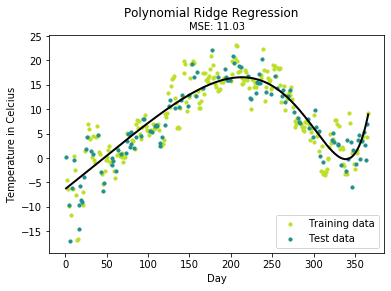

In [68]:
# Color map
cmap = plt.get_cmap('viridis')

# Predict for all points in set
y_val = model.predict(full_feature_set_for_plot)

# Plot the results
m1 = plt.scatter(366 * train_set_x, train_set_y, color=cmap(0.9), s=10)
m2 = plt.scatter(366 * test_set_x, test_set_y, color=cmap(0.5), s=10)
plt.plot(366 * full_feature_set_for_plot.T, y_val.T, color='black', linewidth=2, label="Prediction")
plt.suptitle("Polynomial Ridge Regression")
plt.title("MSE: %.2f" % mse, fontsize=10)
plt.xlabel('Day')
plt.ylabel('Temperature in Celcius')
plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
plt.show()